In [19]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

from scipy.spatial.distance import cdist
import cv2
from scipy.stats import norm
import time

from IPython import display

np.random.seed(0)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [20]:
import torch
import torch.nn as nn

# create a preference learning model
class PreferenceModel(nn.Module):
    def __init__(self):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # apply the linear layers to each state in the state pair
        x1 = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        x1 = self.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        # split the output as 2 values, one as the predicted reward, the other as the uncertainty in the predicted reward
        u1 = x1[:, 0].unsqueeze(1)
        #s1 = torch.abs(x1[:, 1].unsqueeze(1)) # make the standard deviation always positive
        # repeat for state 2
        x2 = self.relu(self.fc1(x[:, 1].unsqueeze(1)))
        x2 = self.relu(self.fc2(x2))
        x2 = self.fc3(x2)
        # split the output as 2 values, one as the predicted reward, the other as the uncertainty in the predicted reward
        u2 = x2[:, 0].unsqueeze(1)
        #s2 = torch.abs(x2[:, 1].unsqueeze(1)) # make the standard deviation always positive
        # sample a reward from a normal distribution with the predicted reward and uncertainty
        #r1 = torch.normal(u1, s1)
        #r2 = torch.normal(u2, s2)
        # return the sampled preference
        return self.sigmoid(u1 - u2)
    
    def predict_reward(self, x):
        r = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        r = self.relu(self.fc2(r))
        r = self.fc3(r)
        return r

model = PreferenceModel()
    
checkpoint_path = 'models/best_model_1.pt'  # Replace with your file path
checkpoint = torch.load(checkpoint_path)

# Load the parameters into the model
model.load_state_dict(checkpoint)
model.eval()  # Set the model to evaluation mode if needed

PreferenceModel(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [21]:
class grid_env():
    
    def __init__(self, sparse=True):
        self.sparse = sparse
        right_most = 2.0
        left_most = -2.0
        grid_size = 0.01
        goal_location = 1.0
        self.N = int((right_most - left_most)/grid_size + 1) # size of the grid map
        
        x_arr = np.arange(self.N) # create x coord array

        self.xl = int((goal_location - left_most)/grid_size) # index of the goal

        self.fv = lambda x : np.exp(-1*(x-self.xl)**2) # e^(-dist^2). gaussian proximity reward function
        
        if sparse:
            self.f = self.fv(x_arr) # reward vector
        else:
            real_valued_states = torch.arange(-2.0, 2.01, 0.01).unsqueeze(1)
            rewards = model.predict_reward(real_valued_states)
            self.f = rewards[:, 0].detach().numpy()
        
        self.state = np.random.randint(self.N) # random initial location
        
        self.action_space = np.array([-1, 1]) # up down left right 
        
    # apply action and update the state
    def mm(self,x,u,dt=0.1):
        return x + u
    
    # step one action
    def step(self,idx):
        u = self.action_space[idx]
        new_state = self.mm(self.state,u)
        new_state = np.clip(new_state,0,self.N-1)
        self.state = np.copy(new_state)
        
        # if the gaussian proximity lookup table returns higher than 0.1
        if self.f[new_state] > 0.1:
            feature = 2.0 
        else:
            feature = 0.0 
        # return new state, predicted reward, feature (unused)
        return self.state,self.f[new_state],feature
    

    
    def reset(self):
        self.state = np.random.randint(self.N)
        if self.f[self.state] > 0.1:
            feature = 2.0
        else:
            feature = 0.0
        return np.copy(self.state),feature

In [22]:
# takes in the env, Q table, episode length
# plays one episode
# plots the reward and q value for every step. 
def test_value(env,Q,steps=400,disp=True):
    state,feature = env.reset()
    xm = [] # state
    rsum = 0 # total reward
    for j in range(steps):
        a = np.argmax(Q[state,:]) # select the best action

        state,reward,feature = env.step(a)
    
        xm.append(np.copy(state))
        rsum = rsum+reward
        if disp:
            plt.clf()
            plt.subplot(1,2,1)
            plt.imshow(env.f.reshape((1,-1)),origin='lower',extent=[0,env.N,0,1], aspect="auto")
            plt.title('Actual reward')
            plt.plot(np.vstack(xm))

            plt.subplot(1,2,2)
            plt.imshow(np.max(Q,axis=1).reshape((1,-1)),origin='lower',extent=[0,env.N,0,1], aspect="auto")
            plt.title('Q estimate')
            plt.plot(np.vstack(xm),'-o')
            plt.title(j)

            display.clear_output(wait=True)
            display.display(plt.gcf())
    return rsum, xm

In [38]:
def value_iteration(env,init=None,iters=100, ep_length=500, alpha=0.9,gamma=0.9,eps_greedy_init=0.5,eps_anneal=True,plot_freq=1,disp=True):
    
    if init is None:
        Q = np.ones((env.N,env.action_space.shape[0])) # initialise Q table
    else:
        Q = init
    
    if disp:
        plt.figure(figsize=(15,5))
        if env.sparse:
            reward_title = 'True reward'
        else:
            reward_title = 'Expanded reward'

    converge_iter = 0
    for i in range(iters):
        reward = 0
        xm = []
        rewards = []
        state,feature = env.reset()
        max_diff = 0
        for j in range(ep_length):
            state = np.copy(env.state)
            
            # Epsilon-greedy
            if eps_anneal:
                eps_greedy = eps_greedy_init*np.exp(1-ep_length/(j+1))
            else:
                eps_greedy = eps_greedy_init
                
            if np.random.rand() < eps_greedy:
                a = np.argmax(Q[state,:])
            else:
                a = np.random.randint(env.action_space.shape[0])

            new_state, new_reward,feature = env.step(a)
            xm.append(np.copy(new_state))

            old_q = np.copy(Q[state,a])
            new_a = np.argmax(Q[new_state,:])
            Qmax = Q[new_state,new_a]
            Q[state,a] = (1-alpha)*Q[state,a] + alpha*(reward + gamma*Qmax)
            reward = new_reward
            # find difference
            diff = np.abs(old_q - Q[state,a])
            if diff > max_diff:
                max_diff = diff
            
            rewards.append(reward)
            
            if (j %plot_freq == 0) and (disp):
                fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
                axes[0].imshow(env.f.reshape((1,-1)),origin='lower',extent=[0,env.N,0,1], aspect="auto", cmap="cividis")
    #             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
                axes[0].set_title(reward_title)
                
                axes[1].imshow(np.max(Q,axis=1).reshape((1,-1)),origin='lower',extent=[0,env.N,0,1], aspect="auto", cmap="cividis")
    #             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
                axes[1].set_title('Q value')
                #plt.subplot(2,3,3)
                axes[2].imshow(np.argmax(Q,axis=1).reshape((1,-1)),origin='lower',extent=[0,env.N,0,1], aspect="auto", cmap="cividis")
    #             plt.plot(np.vstack(xm)[:,0],np.vstack(xm)[:,1])
                axes[2].set_title('Best action')
        
                #plt.subplot(2,1,2)
                #plt.plot(rewards,'o',alpha=0.01)
                #plt.ylabel('Reward')
                #plt.xlabel('Env interaction')
                display.clear_output(wait=True)
                plt.show()
                #print (eps_greedy)
        converge_iter = i
        if max_diff < 1e-1:
            print ('Converged in {} iterations'.format(i))
            break
    return Q, converge_iter

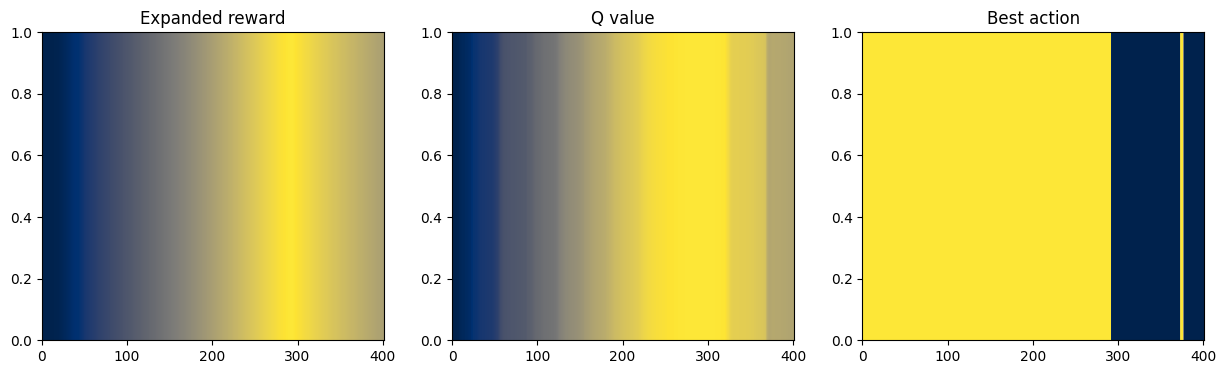

Converged at iteration: 199


In [39]:
#Create new env with estimated reward and train agent
new_env = grid_env(sparse=False)
newQ, converge_iter = value_iteration(new_env,iters=200,ep_length=1000, alpha=0.5,gamma=0.99,eps_greedy_init=0.99,eps_anneal=True,disp=True,plot_freq=1000)

print(f"Converged at iteration: {converge_iter}")



In [ ]:
# Test agent on original world
#rsum,traj = test_value(new_env,newQ,steps=300,disp=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a 1D array of colors (you can use your own data here)
colors = np.random.rand(100)  # Example: Random colors, change this with your 1D array

# Reshape the 1D array to a 2D matrix with a height of 1
color_matrix = colors.reshape((1, -1))

# Plot the 1D array as an image
plt.figure(figsize=(8, 3))  # Adjust the figure size if needed
plt.imshow(color_matrix, aspect='auto')  # Plot the color matrix
plt.xlabel('Element')
plt.ylabel('Color')
plt.title('1D Array as Image')
plt.colorbar()  # Show color bar for reference
plt.show()